## Load documents with IDs

In [4]:
import requests

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [5]:
documents[3]

{'text': "You don't need it. You're accepted. You can also just start learning and submitting homework without registering. It is not checked against any registered list. Registration is just to gauge interest before the start date.",
 'section': 'General course-related questions',
 'question': 'Course - I have registered for the Data Engineering Bootcamp. When can I expect to receive the confirmation email?',
 'course': 'data-engineering-zoomcamp',
 'id': '0bbf41ec'}

## Load Ground Truth

In [3]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df = pd.read_csv(ground_truth_url)

df_ground_truth = df[df.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')


In [6]:
ground_truth[3]

{'question': 'Does this course have a GitHub repository for the sign-up link?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [7]:
doc_idx = {d['id']: d for d in documents}
doc_idx['0227b872']['text']

'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork'

## Index Data

In [8]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Daniel\.cache\huggingface\hub\models--sentence-transformers--multi-qa-MiniLM-L6-cos-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you e

In [14]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [15]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)
    

100%|██████████| 948/948 [02:46<00:00,  5.69it/s] 


## Retrieval

In [19]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

In [20]:
def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [21]:
question_text_vector_knn(dict(
    question="Do I get a certificate",
    course="machine-learning-zoomcamp"
))

[{'question': 'The course has already started. Can I still join it?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Yes, you can. You won’t be able to submit some of the homeworks, but you can still take part in the course.\nIn order to get a certificate, you need to submit 2 out of 3 course projects and review 3 peers’ Projects by the deadline. It means that if you join the course at the end of November and manage to work on two projects, you will still be eligible for a certificate.',
  'id': 'ee58a693'},
 {'question': 'Will I get a certificate if I missed the midterm project?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': "Yes, it's possible. See the previous answer.",
  'id': '1d644223'},
 {'question': 'Will I get a certificate?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Yes, if you finish at least 2 out of 3 proje

## RAG Flow

In [22]:
def build_prompt(query,search_results):
    prompt_template = """
        You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
        Use only the facts from the CONTEXT when answering the QUESTION.

        QUESTION: {question}

        CONTEXT: {context}
        """.strip()
    
    context = ""

    for doc in search_results:
        context = context + f"section: {doc['section']} \nquestion: {doc['question']} \nanswer: {doc['text']} \n\n"

    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [23]:
build_prompt("When does the course start?", question_text_vector_knn(dict(
    question="Do I get a certificate",
    course="machine-learning-zoomcamp"
)))

"You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.\n        Use only the facts from the CONTEXT when answering the QUESTION.\n\n        QUESTION: When does the course start?\n\n        CONTEXT: section: General course-related questions \nquestion: The course has already started. Can I still join it? \nanswer: Yes, you can. You won’t be able to submit some of the homeworks, but you can still take part in the course.\nIn order to get a certificate, you need to submit 2 out of 3 course projects and review 3 peers’ Projects by the deadline. It means that if you join the course at the end of November and manage to work on two projects, you will still be eligible for a certificate. \n\nsection: General course-related questions \nquestion: Will I get a certificate if I missed the midterm project? \nanswer: Yes, it's possible. See the previous answer. \n\nsection: General course-related questions \nquestion: Will I get a certificate? \nanswer: 

In [25]:
from openai import OpenAI

client = OpenAI()

def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [26]:
def rag(query:dict,model='gpt-4o') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'],search_results)
    answer = llm(prompt,model=model)
    return answer

In [27]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [28]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

### Cosine similarity metric

In [29]:
answer_orig = 'Yes, sessions are recorded if you miss one. Everything is recorded, allowing you to catch up on any missed content. Additionally, you can ask questions in advance for office hours and have them addressed during the live stream. You can also ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.7591171

In [30]:
answers= {}

In [ ]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [32]:
answers

{0: {'answer_llm': 'To sign up for the course, please visit the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/). There you can access all the course materials and start following the instructions provided.',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Where can I sign up for the course?',
  'course': 'machine-learning-zoomcamp'},
 1: {'answer_llm': "Yes, you can sign up for the course by following this link provided in the course's FAQ: [Sign Up Link](https://airtable.com/shryxwLd0COOEaqXo).",
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of 

#### gpt-4o


In [ ]:
results_gpt4o = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

In [34]:
import pandas as pd

# CSV data in the cell above -> In this URL
df_gpt4o = pd.read_csv('https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/results-gpt4o.csv')
df_gpt4o.head(20)

,answer_llm,answer_orig,document,question,course
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the provided context does not include any ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp
5,The course videos are pre-recorded. You can st...,"The course videos are pre-recorded, you can st...",39fda9f0,Are the course videos live or pre-recorded?,machine-learning-zoomcamp
6,You can start watching the course videos right...,"The course videos are pre-recorded, you can st...",39fda9f0,When can I start watching the course videos?,machine-learning-zoomcamp
7,"Yes, the live office hours sessions are recorded.","The course videos are pre-recorded, you can st...",39fda9f0,Are the live office hours sessions recorded?,machine-learning-zoomcamp
8,You can find the office hours sessions in the ...,"The course videos are pre-recorded, you can st...",39fda9f0,Where can I find the office hours sessions?,machine-learning-zoomcamp
9,You can access the pre-recorded course videos ...,"The course videos are pre-recorded, you can st...",39fda9f0,Where can I access the pre-recorded course vid...,machine-learning-zoomcamp


#### gpt 3.5-turbo

In [35]:

rag(ground_truth[10], model='gpt-3.5-turbo')

'No, sessions are recorded so you won’t miss anything.'

##### Working with multithreading - For gpt Model without rate limits

In [36]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [37]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [38]:
process_record(ground_truth[10])

{'answer_llm': "Based on the context, sessions are recorded so if you miss one, you won't miss anything.",
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [ ]:
results_gpt35 = map_progress(pool,ground_truth,process_record)

In [ ]:
# Export results to csv
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/results-gpt35.csv', index=False)

In [41]:
df_gpt35 = pd.read_csv('https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/results-gpt35.csv')
df_gpt35

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by going to the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,"I am sorry, but there is no direct link provid...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the course does not have a GitHub reposito...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,Based on the information provided in the FAQ d...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp
...,...,...,...,...,...
1825,"Based on the context from the FAQ database, so...",I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,What are some suggested titles for listing the...,machine-learning-zoomcamp
1826,"Based on the FAQ database context, it is advis...",I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Should I list the Machine Learning Zoomcamp ex...,machine-learning-zoomcamp
1827,You can incorporate your Machine Learning Zoom...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,In which LinkedIn sections can I incorporate m...,machine-learning-zoomcamp
1828,Ani Mkrtumyan gave advice on including a proje...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Who gave advice on including a project link in...,machine-learning-zoomcamp


## Cosine Similarity

#### gpt-4o

In [50]:
def compute_similarity(record):
    llm_vector = model.encode(record['answer_llm'])
    orig_vector = model.encode(record['answer_orig'])

    return llm_vector.dot(orig_vector)

In [48]:
results_gpt4o = df_gpt4o.to_dict(orient='records')
results_gpt4o

[{'answer_llm': 'The CONTEXT provided does not give specific instructions on how to sign up for the course. However, it does mention that you can access the course materials on the course page: [ML Zoomcamp](http://mlzoomcamp.com/). \n\nYou might want to start by visiting the course website and looking for further instructions there, as it likely has additional details on how to sign up or enroll in the course.',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Where can I sign up for the course?',
  'course': 'machine-learning-zoomcamp'},
 {'answer_llm': 'You can sign up for t

In [51]:
similarity_4o = []

for i, record in enumerate(results_gpt4o):
    sim = compute_similarity(record)
    similarity_4o.append(sim)

In [52]:
similarity_4o

[0.5345328,
 0.69612134,
 0.7175137,
 -0.00032766908,
 0.38761967,
 0.97486234,
 0.77259755,
 0.57175744,
 0.8355381,
 0.6982981,
 0.7962799,
 0.69895077,
 0.79451084,
 0.78448904,
 0.61177236,
 0.5452259,
 0.7087172,
 0.36057526,
 0.5786536,
 0.7017782,
 0.74390596,
 0.8385783,
 0.71789783,
 0.42498368,
 0.71905214,
 0.84446365,
 0.8695503,
 0.7565191,
 0.9191264,
 0.8256999,
 0.7075937,
 0.7425105,
 0.66109085,
 0.48071808,
 0.53737354,
 0.5992674,
 0.6581266,
 0.76730734,
 0.63817924,
 0.5259036,
 0.6188005,
 0.6717814,
 0.70310867,
 0.6899211,
 0.62087834,
 0.2681479,
 0.23223813,
 0.20109105,
 0.17891015,
 0.12291355,
 0.79595816,
 0.8727999,
 0.5397216,
 0.8072746,
 0.7109262,
 0.9098751,
 0.7759899,
 0.7067157,
 0.5170927,
 0.51297075,
 0.45277986,
 0.3387072,
 0.11305129,
 0.34532478,
 0.2063625,
 0.7713529,
 0.7654308,
 0.499628,
 0.6007322,
 0.7768923,
 0.8436374,
 0.7786465,
 0.7324002,
 0.6871335,
 0.8920815,
 0.7913782,
 0.8822475,
 0.5981929,
 0.71239376,
 0.51637733,
 0.

In [53]:
df_gpt4o['cosine'] = similarity_4o
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

In [59]:
import seaborn as sns

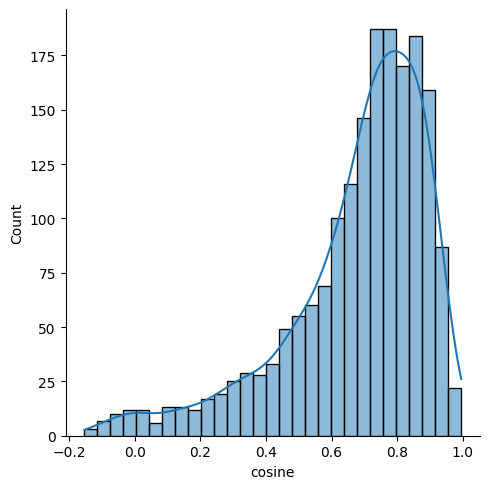

In [62]:
sns.displot(df_gpt4o['cosine'],kde=True)

#### gpt-3.5

In [63]:
results_gpt3_5 = df_gpt35.to_dict(orient='records')
results_gpt3_5

[{'answer_llm': 'You can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials.',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Where can I sign up for the course?',
  'course': 'machine-learning-zoomcamp'},
 {'answer_llm': 'I am sorry, but there is no direct link provided in the FAQ database for signing up for the course. However, you can find a link in the course GitHub repository at this address: https://airtable.com/shryxwLd0COOEaqXo.',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of

In [64]:
similarity_35 = []

for i, record in enumerate(results_gpt3_5):
    sim = compute_similarity(record)
    similarity_35.append(sim)

In [66]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

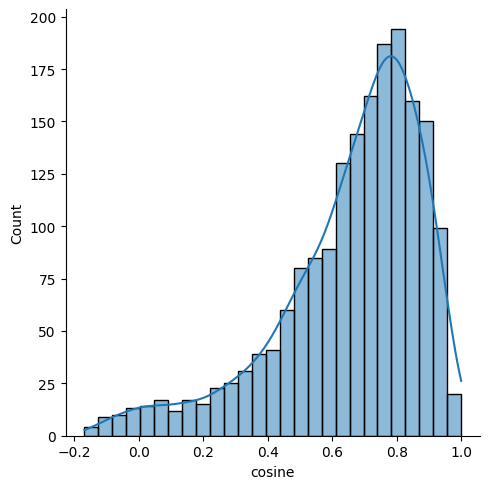

In [67]:
sns.displot(df_gpt35['cosine'],kde=True)

#### gpt-4o-mini

In [65]:
df_gpt4o_mini = pd.read_csv('https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/results-gpt4o-mini.csv')

In [ ]:
results_gpt4o_mini = df_gpt4o_mini.to_dict(orient='records')
results_gpt4o_mini